In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
#os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from i3cols_dataloader import load_events
from likelihood import LLH

%load_ext line_profiler

In [2]:
import tensorflow as tf

In [3]:
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [4]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [5]:
events, labels = load_events(dir='/home/iwsatlas1/peller/work/oscNext/level7_v01.04/140000_i3cols_test')

In [7]:
my_llh = LLH(hitnet_file='models/HitNet_big_11_May_2020-21h09/epoch_200_model.hdf5',
          chargenet_file='models/ChargeNet_L3_12_May_2020-12h26/epoch_75_model.hdf5',
         )

In [16]:
tf.__version__

'2.0.0'

In [56]:
models = (my_llh.hitnet, my_llh.chargenet)

#@tf.function
def freedom_nllh(x, theta, stop_inds, models, charge_ind=4):
    """
    Parameters
     ----------
    x: hits (charge is in column 4)
    theta: hypothesis params
    stop_inds: last index of each separate event in the input
    models: (hitnet, chargenet)
    """
    hitnet = models[0]
    chargenet = models[1]
    # calculate n observations per LLH
    # ensure that sum(n_obs) == len(x) by
    # appending len(x) to the end of stop_inds
    all_inds = tf.concat([[0], [len(x)]], axis=0)
    n_obs = all_inds[1:] - all_inds[:-1]
    # handle zero-padding of dense_theta
    theta = tf.concat([theta, tf.zeros((1, theta.shape[1]), tf.float32)], axis=0)
    #print(theta, n_obs)
    dense_theta = tf.keras.backend.repeat(theta, n_obs) #, axis=0)
    #print(dense_theta)
    # charge net calculation
    charge_splits = tf.split(x[:, charge_ind], n_obs)
    total_charges = tf.stack([tf.reduce_sum(qs) for qs in charge_splits])[:, tf.newaxis]
    charge_ds = chargenet([total_charges, theta])
    charge_llhs = -tf.math.log(charge_ds / (1 - charge_ds))[:, -1]
    # hit net calculation
    hit_ds = hitnet([x, dense_theta])
    hit_llhs = -tf.math.log(hit_ds / (1 - hit_ds))
    hit_llh_splits = tf.split(hit_llhs, n_obs)
    hit_llh_sums = tf.stack(
        [
            tf.matmul(llh, charge_split[:, tf.newaxis], transpose_a=True)
            for llh, charge_split in zip(hit_llh_splits, charge_splits)
        ]
    )
    # combine hitnet and chargenet
    return hit_llh_sums[:, 0, 0] + charge_llhs

In [57]:
x = event['hits']
thetas = event['params'][np.newaxis, :]
stop_inds = np.array([len(event['hits'])], np.int32)

freedom_nllh(x, thetas, stop_inds , models)

tf.Tensor(
[[ 4.7817699e+01  2.6365644e+01 -2.3533931e+02  9.8062627e+03
   1.2172559e+00  2.5237908e+00  1.3234831e+01  6.4953690e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]], shape=(2, 8), dtype=float32) tf.Tensor([21], shape=(1,), dtype=int32)


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [1] [Op:Pack] name: stack/

In [50]:
tf.constant(params).shape._dims

[Dimension(1), Dimension(8)]

# timings

In [11]:
N_test = np.logspace(0, 3, 10)
event = events[333]

timings = []
timings_tf = []

for n in N_test:
    params = np.repeat(event['params'][np.newaxis, :], n, axis=0)
    params += np.random.randn(*params.shape)
    t = %timeit -o llh = my_llh(event, params)
    
    tft =  %timeit -o nllh = freedom_nllh(event['hits'], params, len(event['hits']) - 1 , models)
    
    timings.append(t)

59.1 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


ValueError: in converted code:

    <ipython-input-8-3b996ac965a2>:18 freedom_nllh  *
        all_inds = tf.concat([[0], stop_inds, [len(x)]], axis=0)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/array_ops.py:1431 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_array_ops.py:1257 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py:548 create_op
        compute_device)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:3429 _create_op_internal
        op_def=op_def)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1773 __init__
        control_input_ops)
    /home/iwsatlas1/peller/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 1 but is rank 0 for 'concat' (op: 'ConcatV2') with input shapes: [1], [], [1], [].


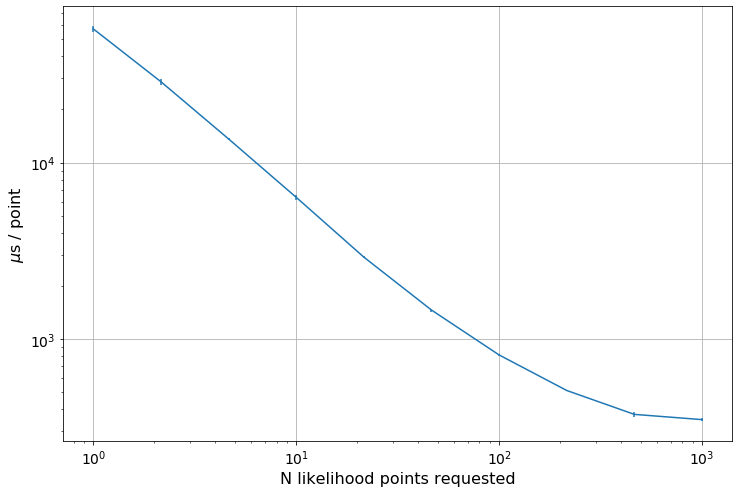

In [10]:
mean = np.array([t.average for t in timings])/N_test * 1e6
std = np.array([t.stdev for t in timings])/N_test * 1e6

plt.errorbar(N_test, mean, yerr=std)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('N likelihood points requested')
plt.gca().set_ylabel(r'$\mu$s / point')
plt.grid()
plt.savefig('timings_cpu_single_vs_tf.png')

In [272]:
len(event['hits'])

21

In [23]:
%lprun -f my_llh.__call__ my_llh(event, np.repeat(event['params'][np.newaxis, :], 10000, axis=0))

Timer unit: 1e-06 s

Total time: 0.927922 s
File: /home/iwsatlas1/peller/freeDOM/freeDOM/likelihood.py
Function: __call__ at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                               def __call__(self, event, params):
    28                                                   """Evaluate LLH for a given event + params
    29                                           
    30                                                   event : dict containing:
    31                                                       'total_charge' : float
    32                                                       'hits' : array shape (n_hits, 5)
    33                                                           each row is (x, y, z) DOM poitions, time, charge
    34                                                   params : ndarray
    35                                                       shape (n_likelihood_points, len(labels)) 
    36        